'\n解释 for i, (ax, img) in enumerate(zip(axes, imgs)):\n\n例如 axes = [ax1,ax2,ax3] imgs = [img1,img2,img3]\nzip返回 (ax1,img1),(ax2,img2),(ax3,img3)\nenumerate为每个配对添加索引\n返回 (0,(ax1,img1)),(1,(ax2,img2)),(2,(ax3,img3))\n\naxes中是各个ax，其中包含各个子图的绘制方法，位置，尺寸大小\nimg就是各张图片具体的像素，用来显示的信息。\n'

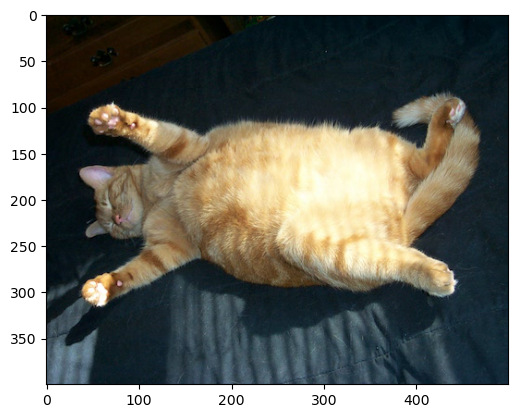

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #解决运行时内核崩溃

# %matplotlib inline
import torch
import torchvision
from torch import nn
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('./img/cat1.jpg')
plt.imshow(img)

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.show()
'''
解释 for i, (ax, img) in enumerate(zip(axes, imgs)):

例如 axes = [ax1,ax2,ax3] imgs = [img1,img2,img3]
zip返回 (ax1,img1),(ax2,img2),(ax3,img3)
enumerate为每个配对添加索引
返回 (0,(ax1,img1)),(1,(ax2,img2)),(2,(ax3,img3))

axes中是各个ax，其中包含各个子图的绘制方法，位置，尺寸大小
img就是各张图片具体的像素，用来显示的信息。
'''

In [2]:
def apply(img,aug,num_rows = 2,num_cols = 4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    show_images(Y,num_rows,num_cols,scale=scale)

**左右翻转图像**

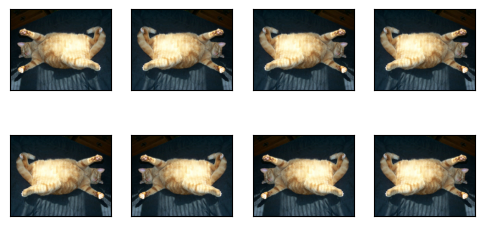

In [3]:
apply(img,torchvision.transforms.RandomHorizontalFlip())

**上下翻转图像**

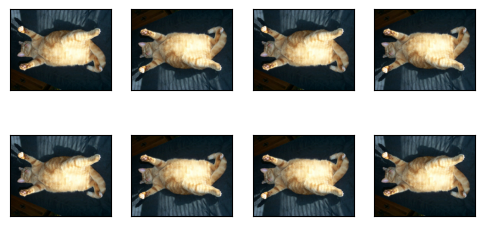

In [4]:
apply(img,torchvision.transforms.RandomVerticalFlip())

**随机剪裁**

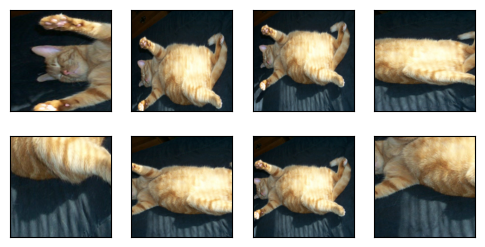

In [5]:
'''最后输出的尺寸是200x200 裁剪的部分尺寸占原始图片的10%到100%  高宽比0.5到2'''
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200,200), scale = (0.1,1), ratio=(0.5,2))
apply(img, shape_aug)

**随机更改图像的亮度**

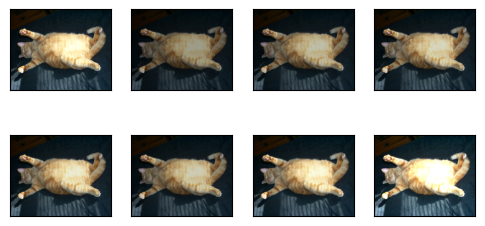

In [6]:
'''
四个参数分别是 亮度 对比度 饱和度 色调
0.5意味着在[-50%,50%]范围内改变
0意味着不改变
'''
apply(img,torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))

**随机更改图像的色调**

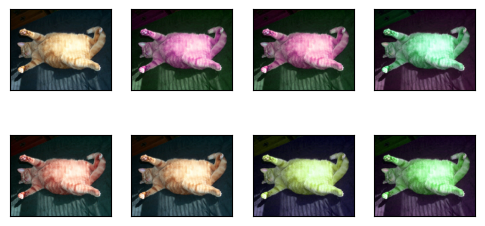

In [7]:
apply(img,torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))

**随机更改图像的亮度(brightness)、对比度(contrast)、饱和度(saturation)和色调(hue)**

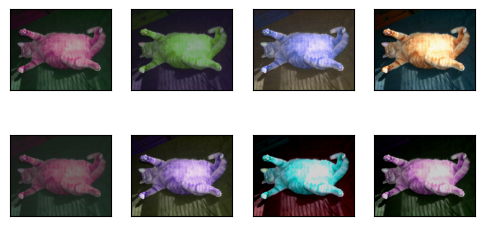

In [8]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)
apply(img,color_aug)

**结合多种图像增广方法**

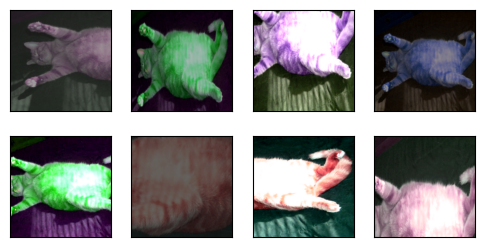

In [9]:
'''随机水平翻转 改变亮度对比度饱和度色调 再随机裁剪'''
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    color_aug,shape_aug])
apply(img,augs)

**使用图像增广进行训练**